DataFrames combined successfully.
Displaying the first 5 rows of the combined DataFrame:
   cardholder_id  transaction_amount  transaction_time transaction_type  \
0       75717013        15081.021530  08/03/2024 22:35             Mail   
1       75717013        14531.455060  12/03/2024 09:26            Phone   
2       75717013          426.425599  17/03/2024 23:28           Online   
3       75717013         2856.830295  19/03/2024 22:43           Manual   
4       75717013        19346.212250  20/03/2024 15:50           Manual   

   is_fraud    birthday location expiration_date  card_number  bin_number  \
0     False  10/06/1998       MA          Jul-27     53989795      539897   
1     False  10/06/1998       MA          Jul-27     53989795      539897   
2     False  10/06/1998       MA          Jul-27     53989795      539897   
3     False  10/06/1998       MA          Jul-27     53989795      539897   
4     False  10/06/1998       MA          Jul-27     53989795      539897  

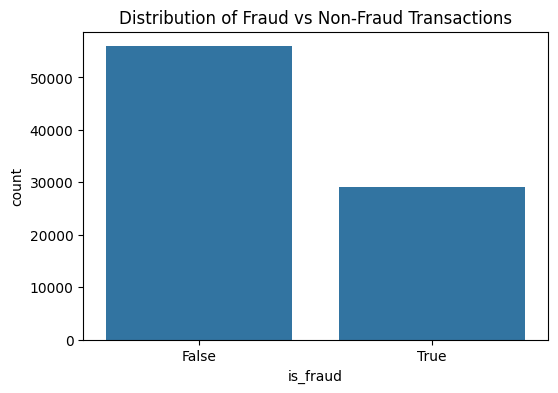


Summary statistics of the dataset:
       cardholder_id  transaction_amount   card_number     bin_number  \
count   8.500000e+04        85000.000000  8.500000e+04   85000.000000   
mean    5.529354e+07         4309.745849  5.354116e+07  535411.073188   
std     2.555898e+07         7724.437804  2.581843e+07  258184.293273   
min     1.044048e+07            1.006778  1.040340e+07  104034.000000   
25%     3.345552e+07           38.841902  3.079874e+07  307987.000000   
50%     5.570631e+07          666.250586  5.199974e+07  519997.000000   
75%     7.779557e+07         4432.583905  7.584712e+07  758471.000000   
max     9.972765e+07        39997.882840  9.990838e+07  999083.000000   

       network_code       distance           MTI  processing_code  \
count       85000.0   85000.000000  85000.000000     85000.000000   
mean            1.0  308663.078824   1395.661129        26.624965   
std             0.0  173916.818014    197.227244        20.595893   
min             1.0     600.00

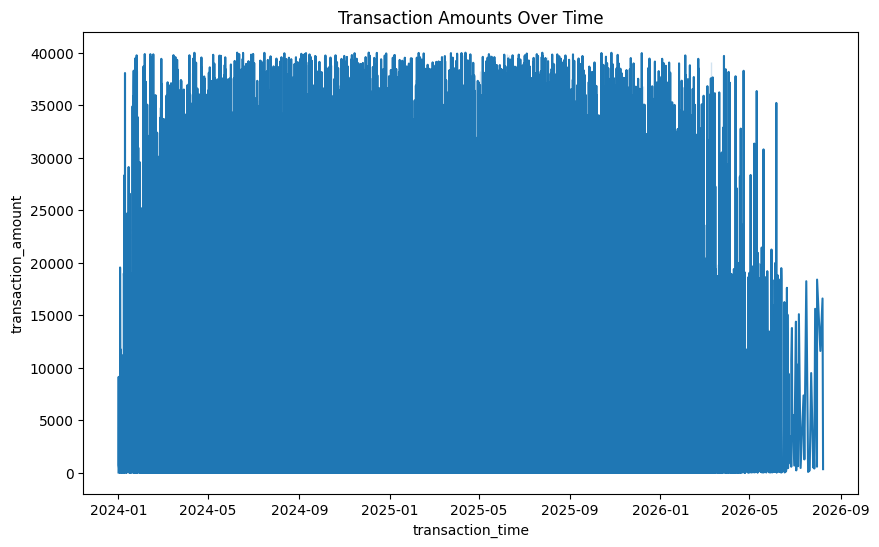


Data types of features:
cardholder_id                       int64
transaction_amount                float64
transaction_type                    int64
location                            int64
card_number                         int64
bin_number                          int64
network_code                        int64
transaction_currency                int64
distance                            int64
Aquiring_country_code               int64
MTI                                 int64
processing_code                     int64
is_recurrent_payment                int64
MCC                                 int64
Terminal_ID                         int64
POS                                 int64
Pin_verified                        int64
CVV_verified                        int64
CAVV_verified                       int64
Cryptogram_verified                 int64
ATC_verified                        int64
CVR/TVR_verified                    int64
Velocity_verified                   int64
Address_v

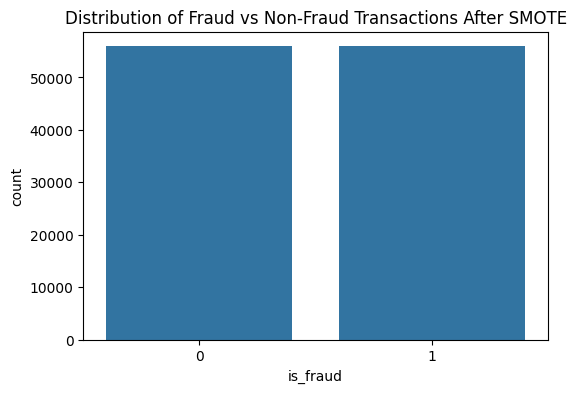

In [20]:
#preprocessing step
!pip install catboost
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# define the standard column order to ensure consistency across different CSV files in case of column mismatch
standard_columns = [
    'cardholder_id', 'transaction_amount', 'transaction_time', 'transaction_type', 'is_fraud', 'birthday',
    'location', 'expiration_date', 'card_number', 'bin_number', 'network_code', 'transaction_currency',
    'distance', 'Aquiring_country_code', 'MTI', 'processing_code', 'is_recurrent_payment', 'MCC', 'Terminal_ID', 'POS',
    'outlet_address', 'outlet_URL_mail', 'Pin_verified', 'CVV_verified', 'CAVV_verified', 'Cryptogram_verified',
    'ATC_verified', 'CVR/TVR_verified', 'Velocity_verified', 'Address_verified', 'Account_verified', 'Available_checked',
    'is_onus_merchant', 'is_card_present', 'is_wallet', 'is_token_based'
]

# List of CSV file paths to be pre-processed
csv_files = [
    '/content/fake_fraud_data_rule_2.csv',
    '/content/fake_fraud_data_rule_3.csv',
    '/content/fake_fraud_data_rule_20.csv',
    '/content/fake_fraud_50.csv',
    '/content/fake_fraud_data_rule_49.csv',
    '/content/fake_fraud_data_rule_15.csv',
    '/content/fake_fraud_data_rule_23.csv'
]

def standardize_columns(df, standard_columns):

    #add missing columns with NaN values to ensure consistency across datasets.
    for col in standard_columns:
        if col not in df.columns:
            df[col] = pd.NA
    df = df[standard_columns]
    return df

# Combining all CSV files into one DataFrame
df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        df = standardize_columns(df, standard_columns)
        df_list.append(df)
    except FileNotFoundError:
        print(f"Error: File {file} not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: File {file} is empty.")
    except pd.errors.ParserError:
        print(f"Error: File {file} could not be parsed.")
    except Exception as e:
        print(f"An unexpected error occurred with file {file}: {e}")

# Combining all data into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)
print("DataFrames combined successfully.")
print("Displaying the first 5 rows of the combined DataFrame:")
print(combined_df.head())

# Data visualization: Distribution of fraud vs. non-fraud transactions
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=combined_df)
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

# data statistics
print("\nSummary statistics of the dataset:")
print(combined_df.describe())

# Check for missing values
print("\nMissing values in each column:")
print(combined_df.isnull().sum())

# Feature Engineering :

# Convert 'transaction_time' to datetime and extract time-based features : preforming feature engineering
combined_df['transaction_time'] = pd.to_datetime(combined_df['transaction_time'], format='%d/%m/%Y %H:%M')
combined_df['transaction_hour'] = combined_df['transaction_time'].dt.hour
combined_df['transaction_day_of_week'] = combined_df['transaction_time'].dt.dayofweek
combined_df['transaction_month'] = combined_df['transaction_time'].dt.month

# Visualization: transaction amounts over transaction time
plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_time', y='transaction_amount', data=combined_df)
plt.title('Transaction Amounts Over Time')
plt.show()

# Calculate the age of the cardholder at the time of the transaction
combined_df['birthday'] = pd.to_datetime(combined_df['birthday'], format='%d/%m/%Y')
combined_df['age_of_cardholder'] = combined_df['transaction_time'].dt.year - combined_df['birthday'].dt.year

# Calculate the days left before the card expires at the time of the transaction
combined_df['expiration_date'] = pd.to_datetime(combined_df['expiration_date'], format='%b-%y')
combined_df['card_validity_left'] = (combined_df['expiration_date'] - combined_df['transaction_time']).dt.days

# Encode categorical variables using label encoding before SMOTE
categorical_columns = ['location', 'network_code', 'transaction_currency',
                       'Aquiring_country_code', 'transaction_type', 'POS']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col].astype(str))
    label_encoders[col] = le

# Convert binary column from true / false to binary 1/0
binary_columns = ['is_recurrent_payment', 'Pin_verified', 'CVV_verified', 'CAVV_verified',
                  'Cryptogram_verified', 'ATC_verified', 'CVR/TVR_verified', 'Velocity_verified',
                  'Address_verified', 'Account_verified', 'Available_checked', 'is_onus_merchant',
                  'is_card_present', 'is_wallet', 'is_token_based']

combined_df[binary_columns] = combined_df[binary_columns].astype(int)

# Feature engineering for binary columns: summing up the number of verification checks passed
combined_df['number_of_verifications_passed'] = combined_df[binary_columns].sum(axis=1)

# Convert 'is_fraud' target column to binary
combined_df['is_fraud'] = combined_df['is_fraud'].astype(int)

# Clean and handle text fields :
# Extracting postal codes from outlet_address and handle scientific notation in 'POS' :
combined_df['outlet_address'] = combined_df['outlet_address'].str.extract(r'(\w+,\s\w+ \d{5})')
combined_df['POS'] = combined_df['POS'].apply(lambda x: float(x) if isinstance(x, str) and 'E' in x else x)

# Drop irrelevant columns for our classification goal before SMOTE
combined_df.drop(columns=['outlet_address', 'outlet_URL_mail', 'birthday', 'expiration_date', 'transaction_time'], inplace=True)

# Define features X and Y
X = combined_df.drop('is_fraud', axis=1)
y = combined_df['is_fraud']

# Display data types of features for better visualization
print("\nData types of features:")
print(X.dtypes)

# Apply SMOTE to balance the dataset by oversampling to make fraud true and false equal
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualization: Distributions of fraud vs non-fraud transactions after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Distribution of Fraud vs Non-Fraud Transactions After SMOTE')
plt.show()

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Preprocessing step is done


0:	test: 0.6883797	best: 0.6883797 (0)	total: 120ms	remaining: 8m
100:	test: 0.9704549	best: 0.9704549 (100)	total: 11.2s	remaining: 7m 11s
200:	test: 0.9795326	best: 0.9795326 (200)	total: 24s	remaining: 7m 33s
300:	test: 0.9823940	best: 0.9824089 (292)	total: 36.2s	remaining: 7m 25s
400:	test: 0.9837906	best: 0.9838228 (397)	total: 49.2s	remaining: 7m 21s
500:	test: 0.9844676	best: 0.9844676 (500)	total: 1m 1s	remaining: 7m 10s
600:	test: 0.9848639	best: 0.9848675 (595)	total: 1m 14s	remaining: 6m 58s
700:	test: 0.9852713	best: 0.9852716 (698)	total: 1m 26s	remaining: 6m 47s
800:	test: 0.9855686	best: 0.9856146 (779)	total: 1m 39s	remaining: 6m 37s
900:	test: 0.9858184	best: 0.9858244 (899)	total: 1m 50s	remaining: 6m 21s
1000:	test: 0.9860132	best: 0.9860132 (1000)	total: 2m 2s	remaining: 6m 6s
1100:	test: 0.9860390	best: 0.9860514 (1005)	total: 2m 14s	remaining: 5m 54s
1200:	test: 0.9862804	best: 0.9862950 (1197)	total: 2m 27s	remaining: 5m 44s
1300:	test: 0.9862871	best: 0.9863252

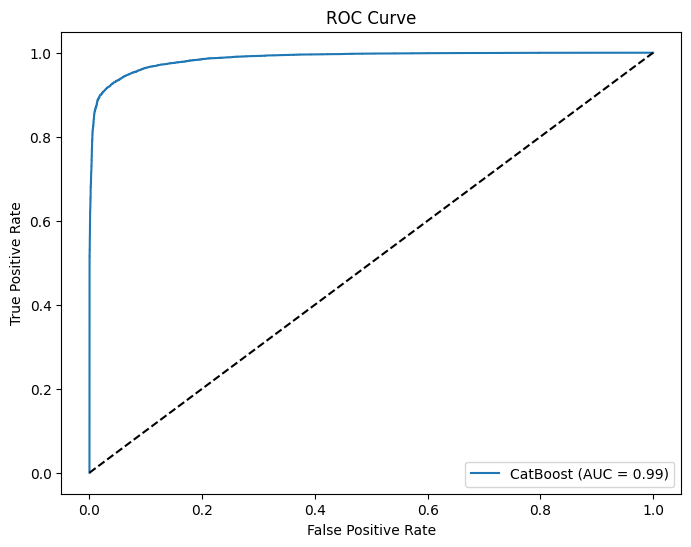

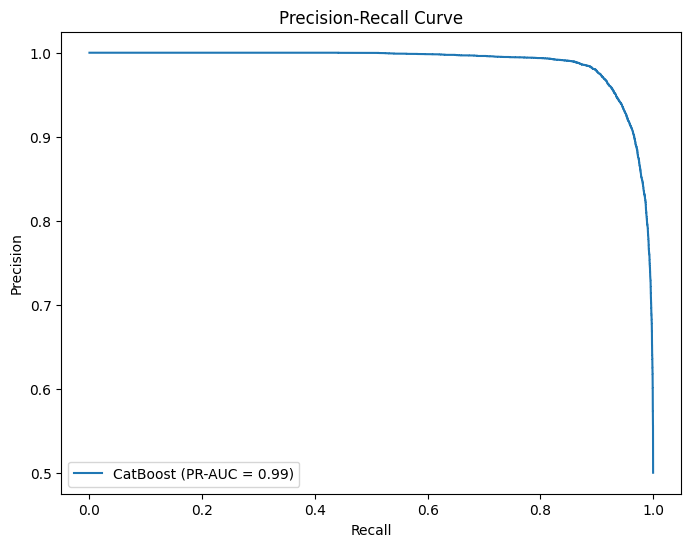

In [27]:
# Importing the necessary libraries
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initializing the CatBoost model with early stopping :
catboost_model = CatBoostClassifier(
    iterations=4000,
    learning_rate=0.4,
    depth=4,
    eval_metric='AUC',
    l2_leaf_reg=12,
    random_seed=42,
    bagging_temperature=0.2,
    cat_features=[X_train.columns.get_loc(col) for col in categorical_columns],
    early_stopping_rounds=300,
    verbose=100
)

# Training the model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Predicting and evaluating using a custom threshold
y_test_pred_proba = catboost_model.predict_proba(X_test)[:, 1]
optimal_threshold = 0.7
y_test_pred_custom = (y_test_pred_proba >= optimal_threshold).astype(int)

# Evaluating the custom threshold
custom_accuracy = accuracy_score(y_test, y_test_pred_custom)
print(f"Custom Accuracy: {custom_accuracy:.5f}")

#confusion matrix evaluation :
print("\nConfusion Matrix (CatBoost - Test):")
print(confusion_matrix(y_test, y_test_pred_custom))

print("\nClassification Report (CatBoost - Test):")
print(classification_report(y_test, y_test_pred_custom))

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

# recall
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.5f}")

# presicion
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC Score: {pr_auc:.5f}")

# F1 Score
f1 = (2 * precision[-1] * recall[-1]) / (precision[-1] + recall[-1])
print(f"F1 Score: {f1:.5f}")

# training accuracy
train_accuracy = accuracy_score(y_train, catboost_model.predict(X_train))
print(f"\nAccuracy Score (Train): {train_accuracy:.5f}")

# testing accuracy
print(f"Accuracy Score (Test): {custom_accuracy:.5f}")

# Ploting the ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Ploting the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'CatBoost (PR-AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()
